In [5]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
from scipy.spatial import distance
import matplotlib.pyplot as plt
ep=10
import math
import itertools

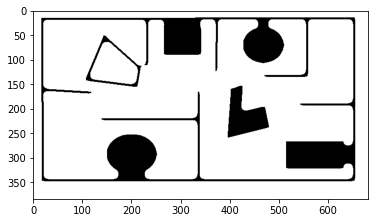

In [6]:
#assuming the robot is circular in shape
def configspace(img,L):
    circle=np.zeros([2*L,2*L,3],dtype=np.uint8)
    circle=cv2.circle(circle,(L,L), L, (255,255,255), -1)
    struct_element=cv2.cvtColor(circle, cv2.COLOR_BGR2GRAY)
    struct_element[struct_element>0]=1
    # plt.imshow(struct_element.astype(np.uint8))
    # print(struct_element)
    closing = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct_element)
    return closing

img=cv2.imread("untitled.png")
# plt.imshow(img.astype(np.uint8))
closed=configspace(img, 10)
plt.imshow(closed.astype(np.uint8))


In [34]:
def rrt_holon(img, t1, t2):
    ep=10
    gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
    config=configspace(img,10) #updated obstacles
    path = []
    for i in range(100):
        available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
        qRand = available[np.random.randint(0,len(available))]
        calc = distance.cdist(t1,[qRand])
        qNear = t1[np.argmin(calc)]
        u = qRand - qNear
        if np.linalg.norm(u) == 0: continue
        v = u / np.linalg.norm(u)
        qNew = qNear + ep*v
        qNew = np.asarray(qNew,dtype=np.int64) 
        imgcpy = config.copy()
        prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
#         newline = np.array(np.where((imgcpy == [0, 0, 255]).all(axis = 2))).T
#         flg = 1
        newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        if prevobs == newobs:
            cv2.line(config,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
#             tem = gra[(qNear[0],qNear[1])]
            path.append([qNear[0],qNear[1],qNew[0],qNew[1]])
#             gra[(qNew[0],qNew[1])] = tem
            t1 = np.vstack([t1,qNew])
#             available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
        plt.imshow(config.astype(np.uint8))
        if np.min(distance.cdist(t1,t2)) < 10 : 
#             print(tem)
            path.append([qNew[0],qNew[1],t2[0][0],t2[0][1]])
            return path
#             break
        

In [13]:
def rrt_holon_recur(img, t1, t2,cnt = 0):
    ep=10
#     cnt += 1
    if cnt == 500 :
        return False,[]
    gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
    config=img #updated obstacles
    available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
    qRand = available[np.random.randint(0,len(available))]
    calc = distance.cdist(t1,[qRand])
    qNear = t1[np.argmin(calc)]
    u = qRand - qNear
    if np.linalg.norm(u) == 0: continue
    v = u / np.linalg.norm(u)
    qNew = qNear + ep*v
    qNew = np.asarray(qNew,dtype=np.int64) 
    imgcpy = config.copy()
    prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
    cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
    newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
    if prevobs == newobs:
        cv2.line(config,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
        tem = gra[(qNear[0],qNear[1])]
        tem.append([qNear[0],qNear[1],qNew[0],qNew[1]])
        gra[(qNew[0],qNew[1])] = tem
        t1 = np.vstack([t1,qNew])
#         print(qNew)
#             available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
    plt.imshow(config.astype(np.uint8))
    if np.min(distance.cdist(t1,t2)) < 10: 
#         print("tem")
        gra[(qNew[0],qNew[1])].append([qNew[0],qNew[1],t2[0][0],t2[0][1]])
        return True,[[qNew[0],qNew[1],t2[0][0],t2[0][1]],[qNear[0],qNear[1],qNew[0],qNew[1]]]
    tem,pat = rrt_holon_recur(config,t1,t2,cnt)
    if tem == True:
        pat.append([qNear[0],qNear[1],qNew[0],qNew[1]])
        return True,pat
    return False,pat
#             break
        

In [35]:
def dfs(cur,des,path):
    global gra
    global vis
    path.append(cur)
    if cur == des:
        print(path)
    vis[cur] = 1
    if len(gra[cur]) > 0:
        for pt in gra[cur]:
            if vis[pt] == 0:
                dfs(pt,des,path)       
    path.pop()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(20, 20), (28, 25), (35, 31), (34, 40), (43, 41), (52, 43), (59, 49), (59, 58), (60, 67), (54, 75), (61, 81), (67, 88), (70, 97), (79, 99), (88, 100), (96, 94), (100, 100)]


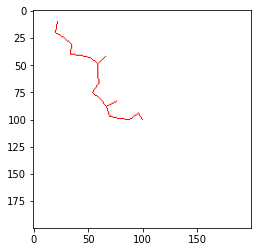

In [36]:
t1 = [[20,20]]
t2 = [[100,100]]
t1 = np.asarray(t1)
t2 = np.asarray(t2)
img = 255*np.ones((200,200,3))
gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
vis = {(x,y) : 0 for x in range(img.shape[0]) for y in range(img.shape[1])}

# cost = 100000000 * np.ones(img.shape)
# cost[t1[0]] = 0
# img1 = cv2.imread("untitled.png")
# cv2.line(img,(25,15),(25,175),(0,0,0),2)
# img1=cv2.imread("/content/maze.png")
# available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
path = rrt_holon(img,t1,t2)
# print(path)
for x1,y1,x2,y2 in path:
#     print(x1,y1,x2,y2)
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0))
    gra[tuple([x1,y1])].append(tuple([x2,y2]))
# vis = np.zeros(img.shape)
tem = []
dfs(tuple(t1[0]),tuple(t2[0]),tem)
qu = []
qu.append(tuple(t1[0]))
plt.imshow(img)
# print(t2[0][0],t2[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(20, 20), (28, 25), (35, 31), (34, 40), (43, 41), (52, 43), (59, 49), (59, 58), (60, 67), (54, 75), (61, 81), (67, 88), (70, 97), (79, 99), (88, 100), (96, 94), (100, 100)]


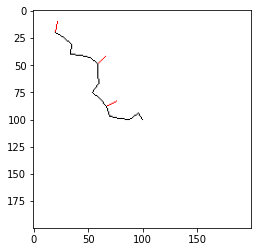

In [40]:
tem = [(20, 20), (28, 25), (35, 31), (34, 40), (43, 41), (52, 43), (59, 49), (59, 58), (60, 67), (54, 75), (61, 81), (67, 88), (70, 97), (79, 99), (88, 100), (96, 94), (100, 100)]
print(tem)
for i in range(len(tem) - 1):
    x1 = tem[i][0]
    y1 = tem[i][1]
    x2 = tem[i + 1][0]
    y2 = tem[i + 1][1]
    cv2.line(img,(x1,y1),(x2,y2),(0,0,0))
plt.imshow(img)
#     gra[tuple([x1,y1])].append(tuple([x2,y2]))

In [5]:
def rrt_nonholon(img, t1, t2):
    init_theta=0
    del_t=1
    for i in range(500):
        available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
        qRand = available[np.random.randint(0,len(available))]
        calc = distance.cdist(t1,[qRand])
        qNear = t1[np.argmin(calc)]

        v, w = [-5, 5], [-math.pi/30, 0, math.pi/30]
        controls = list(itertools.product(v, w))
        max_dist = np.inf
        theta = 0
        qNew=[0,0]

        for crtl in controls:
            v1, w1 = crtl
            temp = [qNear[0] + v1*del_t*math.cos(init_theta + w1*del_t) , qNear[1] + v1*del_t*math.sin(init_theta + w1*del_t)]
            dist = np.linalg.norm(np.array(qRand)-np.array(temp))
            if dist < max_dist:
                qNew = temp
                theta = (init_theta + w1*del_t)
                max_dist = dist
        init_theta=theta
        qNew = np.asarray(qNew,dtype=np.int64)

        imgcpy = img.copy()
        prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))

        newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        if prevobs == newobs:
            cv2.line(img,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
            t1 = np.vstack([t1,qNew])
#         plt.figure()
        plt.imshow(img.astype(np.uint8))
        if np.min(distance.cdist(t1,t2)) < 10 : 
            break

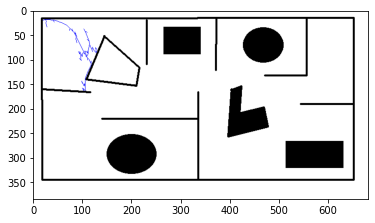

In [7]:
t1 = [[20,20]]
t2 = [[600,150]]
t1 = np.asarray(t1)
t2 = np.asarray(t2)
img = 255*np.ones((200,200,3))
img1 = cv2.imread("untitled.png")
cv2.line(img,(25,15),(25,175),(0,0,0),2)
# plt.imshow(img1)
# available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
rrt_nonholon(img1,t1,t2)